In [1]:
import sys; sys.path.append("..")
from importlib import reload
import persist_to_disk as ptd
import os
ptd.config.set_project_path(os.path.abspath("../"))
import tqdm
import pandas as pd
import numpy as np
import re
import torch
import utils

from _settings import GEN_PATHS

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

import pipeline.uq_bb as uq_bb
reload(uq_bb)

path = GEN_PATHS['coqa']['llama-13b'] 
num_gens = 10
summ_kwargs = {
    'u+ea': {'overall': True, 'use_conf': False},
    'u+ia': {'overall': False, 'use_conf': False},
    'c+ia': {'overall': False, 'use_conf': True},
}['c+ia']

obj = uq_bb.UQ_summ(path, clean=True, split='test', cal_size=1000, seed=1)
summ_obj = obj.summ([
'generations|numsets', 'lexical_sim',
    
        'generations|spectral_eigv_clip|disagreement_w',
        'generations|eccentricity|disagreement_w',
        'generations|degree|disagreement_w',

        'generations|spectral_eigv_clip|agreement_w',
        'generations|eccentricity|agreement_w',
        'generations|degree|agreement_w',


        'generations|spectral_eigv_clip|jaccard',
        'generations|eccentricity|jaccard',
        'generations|degree|jaccard',
    
        'semanticEntropy|unnorm', 'self_prob',
], 
    
    acc_name='generations|gpt|acc',
    num_gens=num_gens, **summ_kwargs
)


INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
# U + EA (using uncertainty to predict expected accuarcy)
summ_obj.summ_overall('auarc')

acc                                                 0.623421
_cnt                                             6983.000000
oracle                                              0.860656
blind                                               0.623421
generations|numsets                                 0.681653
lexical_sim                                         0.772583
generations|spectral_eigv_clip|disagreement_w       0.797517
generations|eccentricity|disagreement_w             0.786658
generations|degree|disagreement_w                   0.797911
generations|spectral_eigv_clip|agreement_w          0.803671
generations|eccentricity|agreement_w                0.794045
generations|degree|agreement_w                      0.800323
generations|spectral_eigv_clip|jaccard              0.787785
generations|eccentricity|jaccard                    0.787043
generations|degree|jaccard                          0.793596
semanticEntropy|unnorm                              0.704652
self_prob               

In [4]:
# C + IA (using confidence to predict individual accuracy)
sum(summ_obj.summ_individual('auarc', use_conf=True)) / num_gens

acc                                                 0.623672
_cnt                                             6983.000000
oracle                                              0.918107
blind                                               0.623672
generations|numsets                                 0.687081
lexical_sim                                         0.784078
generations|spectral_eigv_clip|disagreement_w       0.808903
generations|eccentricity|disagreement_w             0.806089
generations|degree|disagreement_w                   0.840722
generations|spectral_eigv_clip|agreement_w          0.815598
generations|eccentricity|agreement_w                0.841685
generations|degree|agreement_w                      0.841691
generations|spectral_eigv_clip|jaccard              0.798768
generations|eccentricity|jaccard                    0.826269
generations|degree|jaccard                          0.834657
semanticEntropy|unnorm                              0.708018
self_prob               

In [5]:
# C + IA (using confidence to predict individual accuracy)
sum(summ_obj.summ_individual('auroc', use_conf=True)) / num_gens

acc                                                 0.623672
_cnt                                             6983.000000
generations|numsets                                 0.613626
lexical_sim                                         0.712550
generations|spectral_eigv_clip|disagreement_w       0.767263
generations|eccentricity|disagreement_w             0.768380
generations|degree|disagreement_w                   0.834866
generations|spectral_eigv_clip|agreement_w          0.781155
generations|eccentricity|agreement_w                0.839530
generations|degree|agreement_w                      0.841541
generations|spectral_eigv_clip|jaccard              0.752263
generations|eccentricity|jaccard                    0.803309
generations|degree|jaccard                          0.820749
semanticEntropy|unnorm                              0.629377
self_prob                                           0.553023
dtype: float64

# AUARC/AUROC plots

Text(0.5, 1.0, 'ROC')

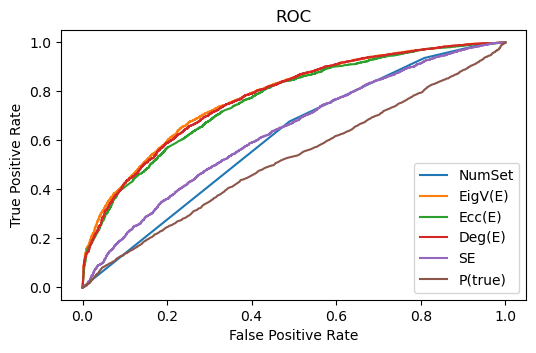

In [6]:
reload(uq_bb)
plt.figure(figsize=(6, 3.5))
def name_map(v):
    if v == 'self_prob': return "P(true)"
    v = v.replace("|disagreement_w", "|(C)")
    v = v.replace("|agreement_w", "|(E)")
    v = v.replace("|jaccard", "|(J)")
    v = v.replace("spectral_eigv_clip|", "EigV")
    v = v.replace("eccentricity|", "Ecc")
    v = v.replace("degree|", "Deg")
    return {'numsets': 'NumSet', 'semanticEntropy|unnorm': 'SE',
            'blind': 'Basse Accuracy'}.get(v,v)
    return v
summ_obj.plot('roc', name_map=name_map, 
              methods=[
                  'generations|numsets',
                       'generations|eccentricity|agreement_w', 
                       'generations|spectral_eigv_clip|agreement_w', 
                       'generations|degree|agreement_w', 
                  'self_prob', 'semanticEntropy|unnorm'], 
              cutoff=1, iloc=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")

#plt.savefig(f"pics/trivia_llama_auroc.pdf", dpi=400, bbox_inches='tight')

Text(0.5, 1.0, 'ARC')

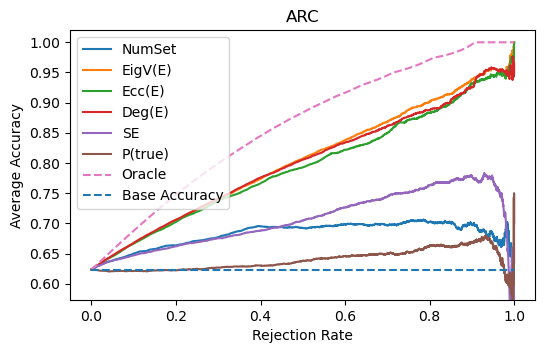

In [7]:
reload(uq_bb)
plt.figure(figsize=(6,3.5))
def name_map(v):
    if v == 'self_prob': return "P(true)"
    v = v.replace("|disagreement_w", "|(C)")
    v = v.replace("|agreement_w", "|(E)")
    v = v.replace("|jaccard", "|(J)")
    v = v.replace("spectral_eigv_clip|", "EigV")
    v = v.replace("eccentricity|", "Ecc")
    v = v.replace("degree|", "Deg")
    return {'numsets': 'NumSet', 'semanticEntropy|unnorm': 'SE', 'oracle': "Oracle",
            'blind': 'Base Accuracy'}.get(v,v)
    return v
summ_obj.plot('arc', name_map=name_map, 
              methods=[
                  'generations|numsets',
                       'generations|eccentricity|agreement_w', 
                       'generations|spectral_eigv_clip|agreement_w', 
                       'generations|degree|agreement_w', 
                       'oracle', 'blind', 'self_prob', 'semanticEntropy|unnorm'], 
              cutoff=1)
plt.xlabel("Rejection Rate")
plt.ylabel("Average Accuracy")
plt.title("ARC")

#plt.savefig(f"pics/coqa_llama_auarc.pdf", dpi=400, bbox_inches='tight')